<a href="https://colab.research.google.com/github/orsegal/CS166/blob/master/CS166_Assignment3_Or_Segal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS166 - Assignment 3 - Network Simulation

### _Or Segal_
***

For this assignment, I will present several modifications for the original network simulation of social dynamics. 

## Part 1 - Model Modifications 
As a modification to the original network, I will aim to model the influence in a social network such as Tweeter. I will do this by modifying the network in several ways:

* Multiple Opinions - Every individual carries opinions on a variety of topics, and cares about each of these topics at a different level. I will incorporate that into the model by setting a vector of opinions on different topics and a vector of weights which indicates how much these topics matter to the individual (weights of topics, all sum to 1). The importance of the topics discussed will determine how the interaction affects the edge weight.
* Several ways for sharing the opinion - tweet, retweet, comment, heart, etc. Each way has a different level of influence on other people (i.e., if someone tweets about a topic, it will have a higher influence than retweeting someone else's tweet, or commenting).
* Directionality of the influence - users are either sharing their opinions or viewing the opinions of others. It is possible to respond to an opinion (comment, heart, etc.) but since it is a process at a larger time scale (compared to an in-person conversation), I will consider here these two as different steps in the simulation.
* Individual characteristics - a set of parameters that change between individuals in the network such as stubbornness, and how often do people get to read their Tweeter feed.

To add all modifications together in a simulation that will represent the dynamics between a set of tweeter users, I will also change the way in which interactions occur (i.e., going over a feed vs. having a conversation). At each step of the simulation a reader will be influenced by the top 5 updates in their feed. The feed will be composed of k influencers (default: 5), which will be chosen at random based on their weights, following the assumption that our feed shows us more often the people that we interact with more and are closer to our opinions (these will have higher edge weights, and the choice will be biased based on the weights). For each influencer, one opinion is randomly selected based on the opinion weights of the influencer (i.e., we post more about the topics we care more about). The opinion of the reader for the same topic is changed based on the general edge weight and the importance of the topic for the reader. We keep a general edge weight based on an assumption that we form an opinion on a person, and then even if they post on a completely different topic, their general credibility and persuasion remains from all other encounters we have had with them.


For the purposes of this assignment, I will first analyze and implement only some of the modifications - the multiple opinions and topic weights - for parts 2-4, as it will be more appropriate for the analysis in part 2. I will then redo parts 3-4 with all the modifications combined.

As a basic implementation, I used the implementation provided with the assignment. See "Appendix A - Part 0" for the basic models.

## Part 2 - Local Analysis

In this section, I will show a local analysis of the system after adding the modification of allowing multiple opinions and setting a weight to each of the topics. 

I used the basic equations for updating the opinions and weights from the update rules of the original model:
$$\begin{align}
\Delta o_{i} &= \alpha w_{ij} (o_j - o_i) \\
\Delta w_{ij} &= \beta w_{ij} (1 - w_{ij}) (1 - \gamma  |o_i - o_j|)
\end{align}$$

The model has three parameters:
* $\alpha$ - Stubbornness, how fast individuals change their opinions to match the opinions of others.
* $\beta$ - Rate of change of the edge weight, how fast individuals change their level of connection (or trust) with others.
* $\gamma$ - How much does the difference in opinion change the weights.


The change in opinions after an interaction is set between the two opinions (which are both on the same topic). The weights of the topics do not matter here, as each topic is only influenced by the general weight of the edge (e.g., we will not get more or less persuaded based on how important is the topic for us). As a result, this equation does not change after the modification of the model. However, the determination of the change in weight will have to account here the importance of the topic. Topics that we care more about will have a higher contribution to the level of trust (or lack of trust) we for people who talk about them. Here, since I do not apply yet the directionality of influence, we will use an average of the topic weights as another parameter $\kappa$ in the $\Delta w_{ij}$ equation. This parameter will be used as fine-tuning to the parameter $\beta$. I will calculate $\kappa$ as an average of the topic weights $T_{i}$ of the two sides: $\kappa = (T_i + T_j)/2$, and it will be added to the $\Delta w_{ij}$ equation in the following way:
$$\Delta w_{ij} = \beta \frac{2(\kappa + 1)}{3} w_{ij} (1 - w_{ij}) (1 - \gamma  |o_i - o_j|)$$
Since $\kappa$ is a parameter with support of (0, 1), we can see that in its extremes it is tunning $\beta$ by a factor of 1/3:
$$\frac{2(\kappa + 1)}{3} \textrm{ where } \kappa \in (0, 1) \rightarrow (\frac{2}{3}, \frac{4}{3})$$

The general behavior of the parameters $\alpha$, $\beta$, and $\gamma$ does not change under the new settings so I will use a basic set of parameters that have been used in the model previously in class ($\alpha=0.03$, $\beta=0.1$, $\gamma=4$) and exemplify the effect of changing $\kappa$.

In [0]:
from matplotlib import pyplot as plt
import networkx as nx
import random
import numpy as np
import scipy
import time
plt.style.use('ggplot')

%matplotlib inline

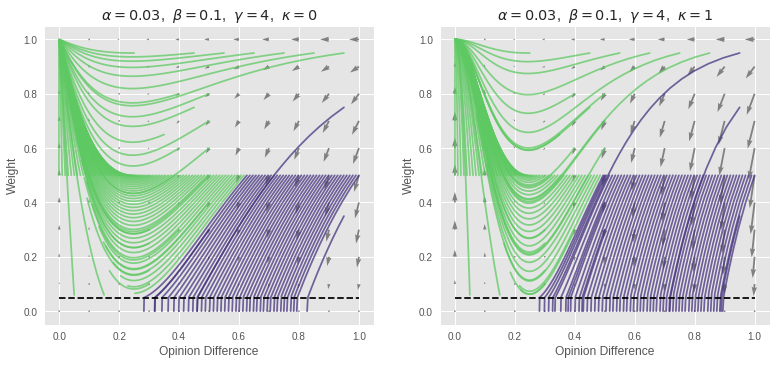

In [2]:
# Part 2 - Vector Field Plot

def draw_vector_plot(ax, alpha = 0.03, beta = 0.3, gamma = 4, kappa = 1):
    '''
    Plot traces of how opinion and weight change over time.
    '''
    cmap = plt.cm.viridis

#     points_to_test = []
    points_to_test = [[0.25, 0.95], [0.45, 0.95], [0.55, 0.95], 
                        [0.65, 0.95], [0.75, 0.95], [0.85, 0.95], 
                        [0.95, 0.95], [0.35, 0.65], [0.45, 0.75], 
                        [0.95, 0.75], [0.95, 0.35], [0.3, 0.25], 
                        [0.3, 0.15], [0.15, 0.06], [0.05, 0.06], 
                        [0.3, 0.3], [0.4, 0.3], [0.4, 0.8], 
                        [0.4, 0.6], [0.5, 0.3], [0.5, 0.4], 
                        [0.5, 0.5], [0.5, 0.6], [0.5, 0.7], 
                        [0.5, 0.8], [0.3, 0.1] ]
    for i in scipy.linspace(0, 1, 100):
        points_to_test.append([i, 0.5])
#     for i in scipy.linspace(0, 1, 100):
#         points_to_test.append([i, 0.66])
#     for i in scipy.linspace(0, 1, 10):
#         for j in scipy.linspace(0, 1, 10):
#             points_to_test.append([i, j])
    
    for opinion, weight in points_to_test:
        ow = [[opinion, 0.0, weight]]
        ##print(ow[-1])
        for i in range(100):
            delta_o = alpha * ow[-1][2] * (ow[-1][1] - ow[-1][0])
            delta_w = ((2/3 * (kappa + 1)) * beta * ow[-1][2] * (1-ow[-1][2]) *(1-gamma*abs(ow[-1][1] - ow[-1][0]))) 
            new_weight = ow[-1][2] + delta_w
            if new_weight < 0.05:
                new_weight = 0
            ow.append([ow[-1][0] + delta_o, ow[-1][1] - delta_o, new_weight])
        ax.plot([row[0] - row[1] for row in ow],
             [row[2] for row in ow],
             color=(cmap(0.15) if ow[-1][2] == 0 else cmap(0.75)), ## ie, at the end of the steps
             alpha=0.75)


    # Plot vector field
    opinion = scipy.linspace(0, 1, 11)  # the difference in opinion, |o_i - o_j|
    weight = scipy.linspace(0, 1, 11)   # the edge weight, w_ij
    ow_grid = scipy.meshgrid(opinion, weight)
    delta_o_grid = -1 * alpha * ow_grid[1] * ow_grid[0]
    delta_w_grid = (2/3 * (kappa + 1)) * beta * ow_grid[1] * (1-ow_grid[1]) * (1 - gamma * ow_grid[0])

    ax.quiver(ow_grid[0], ow_grid[1], ## these are the linearly spaced values
               delta_o_grid, delta_w_grid, ## these are the arrows
               scale=1, color ='grey') 

    # Annotate plot
    ax.set_xlabel('Opinion Difference') 
    ax.set_ylabel('Weight')
    ax.plot([0, 1], [0.05, 0.05], 'k--')
    ax.set_title(r"$\alpha = {}$,  $\beta = {}$,  $\gamma = {}$,  $\kappa = {}$".format(alpha, beta, gamma, kappa))

    
fig, ax = plt.subplots(1, 2, figsize=(13, 5.5))

draw_vector_plot(ax=ax[0], alpha=0.03, beta=0.1, gamma=4, kappa=0)
draw_vector_plot(ax=ax[1], alpha=0.03, beta=0.1, gamma=4, kappa=1)

As we can see in the figures, the effect of $\kappa$ is what we would have expected from the fine-tuning of $\beta$. The system remains well behaved (some cases lead to convergence and some to divergence).

Note that I added 100 traces that start at a weight of 0.5, which is the weight we start the simulation with. This provides additional information about the system's behavior while maintaining a set of additional traces that are more sparsely spread.

## Parts 3-4 - implementation and simulation analysis for the multi-opinion model

As described before, I implemented the multiple opinion modification to the model as well as the topic weights for each of those opinion topics.

For the initial random network, I used the Watts-Strogatz model as I was aiming to model a system with the small-world, scale-free properties. In the case of social networks, these properties have a large influence on the behavior. For example, the fact that the network is scale-free means that there will be nodes (accounts) with a much higher number of edges (followers) as in the case of a random set of Tweeter accounts. 

The modification to the model entailed adding an opinion vector as well as topic-weights vector, both with a size of n_opinions. The opinion vector is initialized with 1/0 for each opinion. The topic-weights vector is set to have a weight in the range (0, 1), where all weights sum to 1. The weights update rule was set according to the description in part 2.

Below we can see early results of the simulation for a single opinion (the basic case we have seen before) and three opinions for each node. In the case of the multiple opinions, each row contains several plotted versions of the network for each displayed time step, where the nodes in the different plotted networks will be colored based on each of the opinions.

In [0]:
# Updated implementation - only multiple opinions
class SocialDynamicsSimulation_MultipleOpinions:
    '''
    Simulate social dynamics by strengthening opinions and connection weights
    based on random interactions between nodes.
    '''

    def __init__(self, network_size=50, alpha=0.03, beta=0.1, gamma=4, n_opinions=5):
        '''
        Inputs:

            network_size (int) The number of nodes in the random Watts-Strogatz
              small-world network. Default: 50.

            alpha (float) The rate at which nodes adjust their opinions to
              match neighboring nodes' opinions during interactions.
              Default: 0.03.

            beta (float) The rate at which edge weights are changed in
              response to differing opinions. Default: 0.3.

            gamma (float) The pickiness of nodes. Nodes with opinions differing
              by more than 1/gamma will result in an edge weight decreasing.
              Default: 4.
            
            n_opinions (int) The number of opinions every person has (topics). The
              opinions are a vector of size n_opinions. Default: 5.
        '''
        self.network_size = network_size
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_opinions = n_opinions
        self.nFeed = 5

    def initialize(self):
        '''
        Initialize the simulation with a random graph.
        Each node has an opinion vector of size n_opinions, and random 
        0 or 1 assigned at random for each opinion and an opinion weight
        vector of size n_opinions which defines the importance weight
        for every opinion, all weights are randomly set between 0 and 1,
        and sum to 1. Initial edge weights are set as 0.5.
        '''
        self.graph = nx.watts_strogatz_graph(50, 5, 0.5)
        for edge in self.graph.edges:
            self.graph.edges[edge]['weight'] = 0.5
        # opinion and opinion_weight vectors
        for node in self.graph.nodes:
            self.graph.nodes[node]['opinions_vector'] = np.random.choice([0., 1.], self.n_opinions)
            temp_weight = np.random.uniform(0, 1, self.n_opinions)
            self.graph.nodes[node]['topic_weights'] = temp_weight/sum(temp_weight)
        self.layout = nx.spring_layout(self.graph)  # Initial visual layout
        self.step = 0

    def observe(self):
        '''
        Draw the state of the network.
        '''
        self.layout = nx.spring_layout(self.graph, pos = self.layout, iterations=5)
        plt.clf()
        nx.draw(
            self.graph, pos=self.layout, with_labels=True,
            node_color=[self.graph.nodes[i]['opinions_vector'][0] for i in self.graph.nodes],
            edge_color=[self.graph.edges[i, j]['weight'] for i, j in self.graph.edges],
            edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=1,
            alpha=0.7, vmin=0, vmax=1, cmap=plt.cm.viridis)
        plt.title('Step: ' + str(self.step))

    def observe_n_opinions(self):
        '''
        Draw the state of the network.
        '''
        if self.n_opinions == 1:
            self.layout = nx.spring_layout(self.graph, pos = self.layout, iterations=5)
            plt.clf()
            nx.draw(
                self.graph, pos=self.layout, with_labels=True,
                node_color=[self.graph.nodes[i]['opinions_vector'][0] for i in self.graph.nodes],
                edge_color=[self.graph.edges[i, j]['weight'] for i, j in self.graph.edges],
                edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=1,
                alpha=0.7, vmin=0, vmax=1, cmap=plt.cm.viridis)
            plt.title('Step: ' + str(self.step))
        else:
            plt.clf()
            fig, ax = plt.subplots(1, self.n_opinions, figsize=(20, 5.5))
            self.layout = nx.spring_layout(self.graph, pos = self.layout, iterations=5)
            for topic in range(self.n_opinions):
    #             plt.clf()
                nx.draw(
                    self.graph, pos=self.layout, with_labels=True,
                    node_color=[self.graph.nodes[i]['opinions_vector'][topic] for i in self.graph.nodes],
                    edge_color=[self.graph.edges[i, j]['weight'] for i, j in self.graph.edges],
                    edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=1,
                    alpha=0.7, vmin=0, vmax=1, ax=ax[topic], cmap=plt.cm.viridis)
                ax[topic].set_title('Step: {}, Topic {}'.format(str(self.step), topic))
            plt.show()

    def update(self):
        if random.uniform(0, 1) < 0.01:
            # Create a new edge with weight 0.5 between two unconnected nodes
            nodes = list(self.graph.nodes)
            while True:
                new_edge = random.sample(nodes, 2)
                if new_edge not in self.graph.edges:
                    break
            self.graph.add_edge(new_edge[0], new_edge[1], weight=0.5)
        else:
            # Select a random edge and update node opinions and edge weight           
            edge = random.choice(list(self.graph.edges))
            
            # Randomly select a post topic
            post_topic = np.random.randint(self.n_opinions)
            
            # Weight and opinions of the edge and nodes
            weight = self.graph.edges[edge]['weight']
            opinions = [self.graph.nodes[n]['opinions_vector'][post_topic] for n in edge]
#             print("Step {}: edge- {}; topic-{}; opinions- ({}, {})".format(self.step, edge, post_topic, opinions[0], opinions[1]))
            
            # Part 1: update nodes' opinions
            for i in [0, 1]:
                self.graph.nodes[edge[i]]['opinions_vector'][post_topic] = (
                    opinions[i] + self.alpha * weight * (opinions[1-i] - opinions[i]))
#                 print(opinions[i] + self.alpha * weight * (opinions[1-i] - opinions[i]))
#                 print(self.graph.nodes[edge[i]]['opinions_vector'][post_topic])
            
            # Part 2: update edge weights
            ## Update kappa (average of topic weights)
            kappa = (self.graph.nodes[edge[0]]['topic_weights'][post_topic] + 
                     self.graph.nodes[edge[1]]['topic_weights'][post_topic]) / 2
            self.graph.edges[edge]['weight'] = (
                weight +
                self.beta * (2/3 * (kappa + 1)) * weight * (1-weight) *
                (1 - self.gamma * abs(opinions[0] - opinions[1])))
            
            # Remove very weak connections
            if self.graph.edges[edge]['weight'] < 0.05:
                self.graph.remove_edge(*edge)
                
        self.step += 1

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


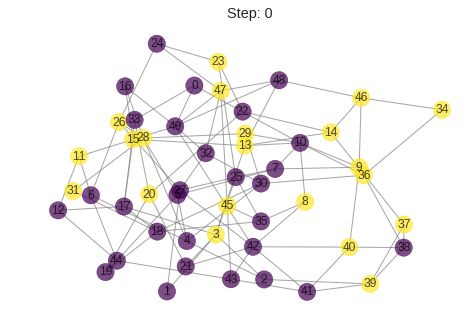

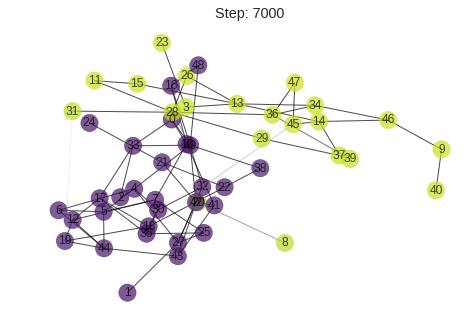

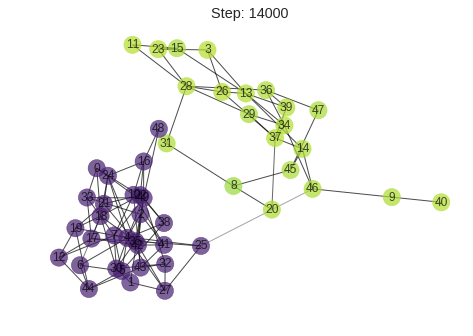

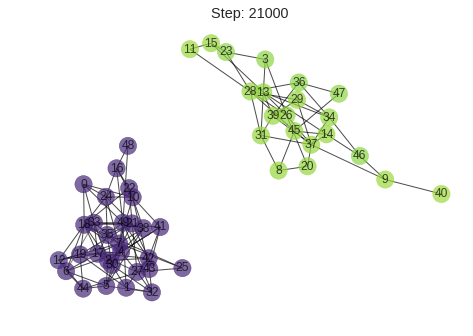

In [4]:
sim = SocialDynamicsSimulation_MultipleOpinions(alpha = 0.03, beta=0.3, n_opinions=1)
# sim = SocialDynamicsSimulation_Single_Opinion(alpha = 0.03, beta=0.3)
# sim = SocialDynamicsSimulation_Tweeter(alpha = 0.03, beta=0.3, n_opinions=5)
sim.initialize()
plt.figure()
sim.observe_n_opinions()
for i in range(3):
    for i in range(7000):
        sim.update()
    plt.figure()
    sim.observe_n_opinions()

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


<Figure size 432x288 with 0 Axes>

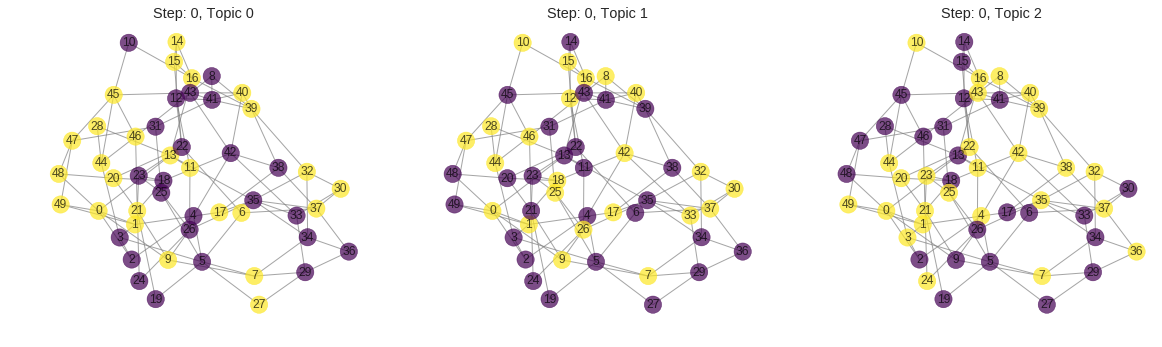

<Figure size 432x288 with 0 Axes>

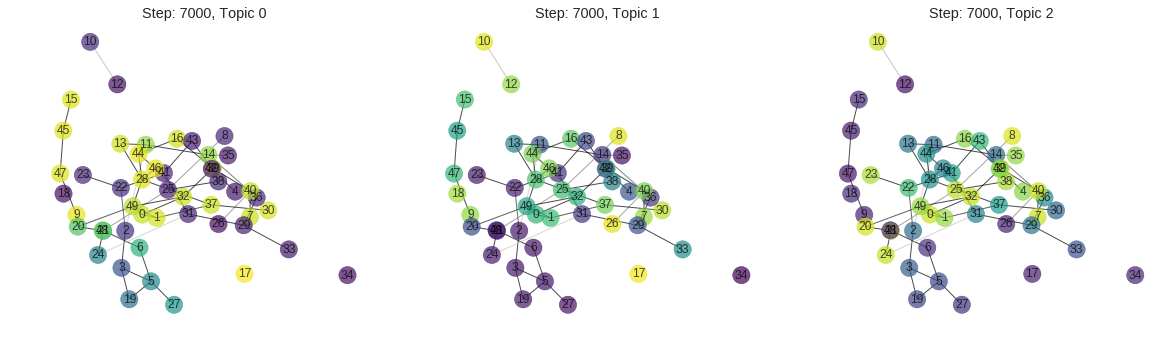

<Figure size 432x288 with 0 Axes>

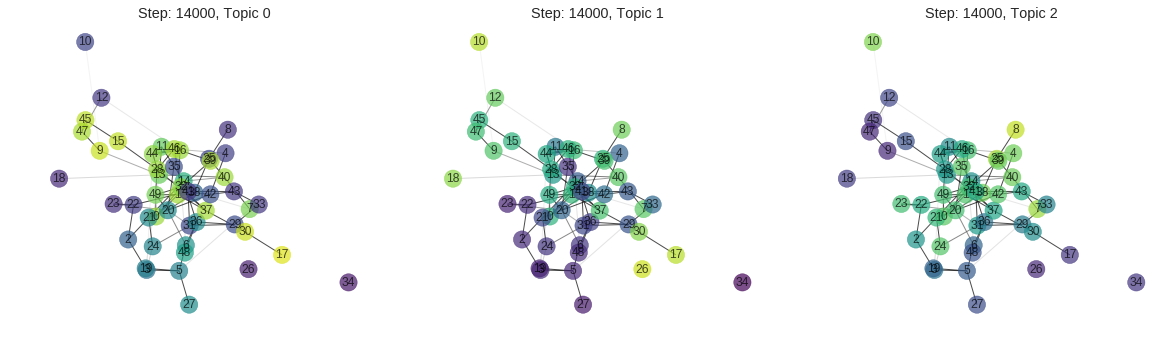

<Figure size 432x288 with 0 Axes>

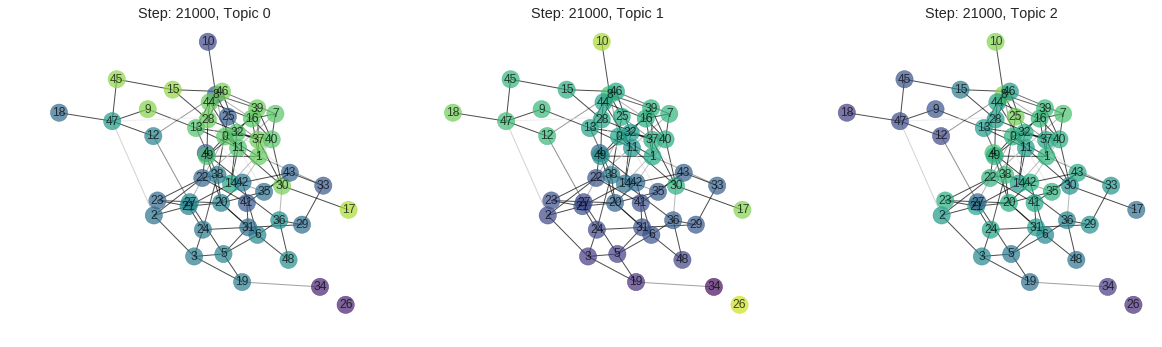

In [5]:
sim = SocialDynamicsSimulation_MultipleOpinions(alpha = 0.03, beta=0.3, n_opinions=3)
# sim = SocialDynamicsSimulation_Single_Opinion(alpha = 0.03, beta=0.3)
# sim = SocialDynamicsSimulation_Tweeter(alpha = 0.03, beta=0.3, n_opinions=5)
sim.initialize()
plt.figure()
sim.observe_n_opinions()
for i in range(3):
    for i in range(7000):
        sim.update()
    plt.figure()
    sim.observe_n_opinions()

As we can see in the examples above, for the case of a single opinion and 3 opinions, there is a clear difference in the formation of distinct clusters (or communities). In the single opinion case, we see that the network is split into two clear communities of uniform opinion with very little or no edges connecting between them. In the case of multiple opinions, we can see that the behavior is more complex than that. For an isolated community to be formed, all of the opinions need to be shared within the community and different from the opinions of others. Due to that, we can see that there are communities that are formed, but they are not completely distinct from the rest of the network. This behavior has a higher resemblance to the real world, as in reality we have many topics that we discuss with people, and having something in common with someone would form a connection even if we do not agree with them on the rest of their opinions.

For a deeper understanding of this behavior, we will use two metrics for the evaluation of communities and clusters in the network. First, we will use NetworkX's average clustering coefficient, which is based on the triangles through that node and defined for weighted graphs as the geometric average of the subgraph (triangles) edge weights (Saramaki et al., 2007):
$$c_i = \frac{1}{deg(i)(deg(i) - 1)}\sum_{jk}(\hat{w}_{ij}\hat{w}_{ik}\hat{w}_{jk})^{1/3}$$


Then, we will use NetworkX's greedy modularity communities (based on the Clauset-Newman-Moore greedy modularity maximization algorithm). Modularity is a metric (between -1 and 1) that compares the density of edges inside a community to the density outside. In the algorithm, small communities are first found by optimizing modularity locally on all nodes. Then they are grouped together to form a larger subgraph in a way that increases the modularity the most (Clauset, Newman, and Moore, 2004).

In [51]:
# Calculating the average clustering coefficient
communities
start_time = time.time()
ave_clust = []
for nop in range(8):
    ave_clust.append([])
    for i in range(100):
        sim = SocialDynamicsSimulation_MultipleOpinions(alpha = 0.03, beta=0.3, n_opinions=nop+1)
        sim.initialize()
        for i in range(20000):
            sim.update()
        ave_clust[-1].append(nx.average_clustering(sim.graph))
    print("\rFinished {0}. Time: {1:.2f} seconds".format((nop+1), time.time()-start_time), end="")
print("\n")

Finished 8. Time: 919.16 seconds



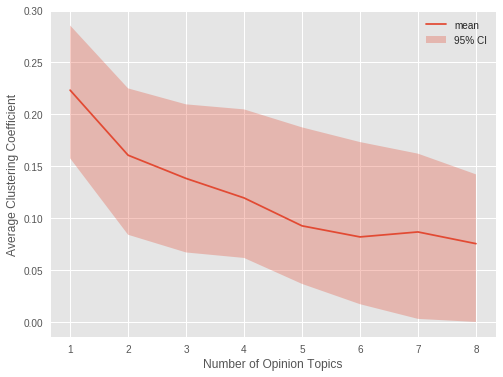

In [52]:
plt.figure(figsize=(8, 6))
plt.plot(range(1,9), ave_clust_per_n, label = "mean")
plt.fill_between(range(1,9), 
                 [np.percentile(cl, 2.5) for cl in ave_clust], 
                 [np.percentile(cl, 97.5) for cl in ave_clust], 
                 alpha = 0.3, label = '95% CI')
plt.xlabel("Number of Opinion Topics")
plt.ylabel("Average Clustering Coefficient")
plt.legend()
plt.show()

In [40]:
# Calculating the number of communities using the Clauset-Newman-Moore greedy modularity maximization algorithm

start_time = time.time()
communities = []
for nop in range(8):
    communities.append([])
    for i in range(50):
        sim = SocialDynamicsSimulation_MultipleOpinions(alpha = 0.03, beta=0.3, n_opinions=nop+1)
        sim.initialize()
        for i in range(20000):
            sim.update()
        communities[-1].append(nx.community.modularity_max.greedy_modularity_communities(sim.graph))
    print("\rFinished {0}. Time: {1:.2f} seconds".format((nop+1), time.time()-start_time), end="")


Finished 8. Time: 462.38 seconds

Mean:  [ 3.06  6.42  7.32  8.68 10.4  12.34 14.56 18.66]


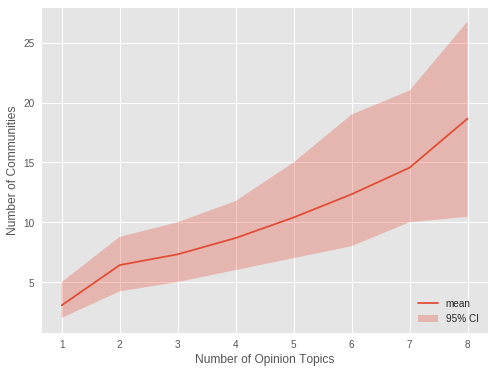

In [50]:
comm_len = []
for i in range(len(communities)):
    comm_len.append([])
    for j in range(len(communities[0])):
        comm_len[-1].append(len(communities[i][j]))
comm_len = np.array(comm_len)

print("Mean: ", np.mean(comm_len, axis=1))

plt.figure(figsize=(8, 6))
plt.plot(range(1,9), np.mean(comm_len, axis=1), label = "mean")
plt.fill_between(range(1,9), 
                 np.percentile(comm_len, 2.5, axis=1), 
                 np.percentile(comm_len, 97.5, axis=1), 
                 alpha = 0.3, label = '95% CI')
plt.xlabel("Number of Opinion Topics")
plt.ylabel("Number of Communities")
plt.legend(loc=4)
plt.show()

As expected, we can see that the average clustering coefficient goes down as the number of opinion topics increases. While the network seems like a large cluster with higher numbers of topics, the cluster is composed of edges with lower weights and is not tightly linked as in the case of the single opinion. Also, we can see that the number of communities goes up as the number of opinion topics increases.  We see that in the single opinion case on average there are about 3 communities (e.g., a single node that does not belong to the two large communities is considered a community on its own) while in the case of 8 opinions there are 18.66 communities on average. That shows us that the network is split into several clusters with lower strength of connection within the clusters which we can interpret as being more diverse but less divided.

## Appendix A - Part 0 - The Basic Model
I originally implemented the basic model myself, so I'll add it here. 
However, to start fresh, I used the provided implementation for the assignment.

See both of the basic implementations (the first one is the one used for the assignment):

In [0]:
# Original implementation brought from https://gist.github.com/cscheffler/f8f8416513356e184e9568fa69c90889 

class SocialDynamicsSimulation_SingleOpinion:
    '''
    Simulate social dynamics by strengthening opinions and connection weights
    based on random interactions between nodes.
    '''

    def __init__(self, network_size=50, alpha=0.03, beta=0.3, gamma=4):
        '''
        Inputs:

            network_size (int) The number of nodes in the random Watts-Strogatz
              small-world network. Default: 50.

            alpha (float) The rate at which nodes adjust their opinions to
              match neighboring nodes' opinions during interactions.
              Default: 0.03.

            beta (float) The rate at which edge weights are changed in
              response to differing opinions. Default: 0.3.

            gamma (float) The pickiness of nodes. Nodes with opinions differing
              by more than 1/gamma will result in an edge weight decreasing.
              Default: 4.
        '''
        self.network_size = network_size
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

    def initialize(self):
        '''
        Initialize the simulation with a random graph, with random 0 or 1
        opinions assigned to all nodes and initial edge weights of 0.5.
        '''
        self.graph = nx.watts_strogatz_graph(50, 5, 0.5)
        for edge in self.graph.edges:
            self.graph.edges[edge]['weight'] = 0.5
        for node in self.graph.nodes:
            self.graph.nodes[node]['opinion'] = random.randint(0, 1)
        self.layout = nx.spring_layout(self.graph)  # Initial visual layout
        self.step = 0

    def observe(self):
        '''
        Draw the state of the network.
        '''
        self.layout = nx.spring_layout(self.graph, pos = self.layout, iterations=5)
        plt.clf()
        nx.draw(
            self.graph, pos=self.layout, with_labels=True,
            node_color=[self.graph.nodes[i]['opinion'] for i in self.graph.nodes],
            edge_color=[self.graph.edges[i, j]['weight'] for i, j in self.graph.edges],
            edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=1,
            alpha=0.7, vmin=0, vmax=1)
        plt.title('Step: ' + str(self.step))

    def update(self):
        if random.uniform(0, 1) < 0.01:
            # Create a new edge with weight 0.5 between two unconnected nodes
            nodes = list(self.graph.nodes)
            while True:
                new_edge = random.sample(nodes, 2)
                if new_edge not in self.graph.edges:
                    break
            self.graph.add_edge(new_edge[0], new_edge[1], weight=0.5)
        else:
            # Select a random edge and update node opinions and edge weight           
            edge = random.choice(list(self.graph.edges))
            weight = self.graph.edges[edge]['weight']
            opinions = [self.graph.nodes[n]['opinion'] for n in edge]
            for i in [0, 1]:
                self.graph.nodes[edge[i]]['opinion'] = (
                    opinions[i] + self.alpha * weight * (opinions[1-i] - opinions[i]))
            self.graph.edges[edge]['weight'] = (
                weight +
                self.beta * weight * (1-weight) *
                (1 - self.gamma * abs(opinions[0] - opinions[1])))
            # Remove very weak connections
            if self.graph.edges[edge]['weight'] < 0.05:
                self.graph.remove_edge(*edge)
        self.step += 1

In [0]:
# My implementation of the model - this implementation was not used in the assignment

class AdaptiveDiffusionSimulation:
    '''
    An implementation of the adaptive diffusion model.
    '''

    def __init__(self, n_nodes=20, node_degree=3):
        '''
        Inputs:

            initial_nodes (int) The number of nodes from which
              the small-world graph starts growing. A complete
              graph with this many nodes will be created when
              the initialize() method below is called.
              Default: 5.

            new_node_degree (int) Every new node that is added
              to the graph will be connected to this many nodes
              in the existing graph.
        '''
        if n_nodes < node_degree:
            raise ValueError(
                'Need at least as many initial nodes (%r) as the new node degree (%r)' %
                (n_nodes, node_degree))
        self.n_nodes = n_nodes
        self.node_degree = node_degree
        self.alpha = 0.03 # diffusion constant
        self.beta = 0.3 # rate of adaptive edge weight change
        self.gamma = 4 # pickiness of nodes
        self.steps = 0

    def initialize(self):
        '''
        Create a new graph for the simulation, starting with a small-world graph using 
        the Barabasi-Albert algorithm.
        '''
        self.graph = nx.barabasi_albert_graph(self.n_nodes, self.node_degree)
        for i, j in self.graph.edges:
            self.graph.edges[i,j]['weight'] = 0.5
        for i in self.graph.nodes:
            self.graph.nodes[i]['state'] = 1 if np.random.uniform(0, 1) > 0.5 else 0
        self.layout = nx.spring_layout(self.graph)
        
    def observe(self):
        '''
        Update the matplotlib figure for the simulation visualization.
        '''
        plt.clf()
        # Plot network layout, color coding nodes by their degree
#         plt.subplot(1, 3, 1)
        degree = np.array([self.graph.degree[i] for i in self.graph.nodes])
        states = np.array([self.graph.nodes[i]['state'] for i in self.graph.nodes])
        nx.draw(
            self.graph, pos=self.layout,
            node_color=-states, alpha=0.8)
        plt.title('Nodes: ' + str(len(degree)))
#         # Histogram of shortest path lengths between all pairs of nodes
#         plt.subplot(1, 3, 2)
#         lengths = []
#         for source, source_lengths in nx.all_pairs_shortest_path_length(self.graph):
#             lengths.extend(x[1] for x in source_lengths.items() if x[0] > source)
#         plt.hist(lengths, bins=10, range=(0.5, 10.5), rwidth=0.8)
#         plt.title('Shortest path distribution')
#         # Histogram of degrees of all nodes
#         plt.subplot(1, 3, 3)
#         plt.hist(degree, bins=10, range=(0.5, 10.5), rwidth=0.8)
#         plt.title('Degree distribution')

    def update(self):
        '''
        Add one new node to the existing graph and connect it to existing
        nodes using preferential attachment.
        '''
        self.steps += 1
        # Select a random edge in the network
        rand_edge = rd.choice(list(self.graph.edges))
        
        # Part 1: change people's opioions
        ## Calculate by how much to change the opinion
        delta_opinion = self.alpha * self.graph.edges[rand_edge]['weight'] * \
                        abs(self.graph.nodes[rand_edge[0]]['state'] - 
                            self.graph.nodes[rand_edge[1]]['state'])
        ## Change the opinions by delta_opinion to bring them closer
        if self.graph.nodes[rand_edge[0]]['state'] > self.graph.nodes[rand_edge[1]]['state']:
            self.graph.nodes[rand_edge[0]]['state'] -= delta_opinion
            self.graph.nodes[rand_edge[1]]['state'] += delta_opinion
        else:
            self.graph.nodes[rand_edge[0]]['state'] += delta_opinion
            self.graph.nodes[rand_edge[1]]['state'] -= delta_opinion
            
        # Part 2: change their relationships
        ## Calculate by how much to change
        delta_weight = self.beta * self.graph.edges[rand_edge]['weight'] * \
                        (1 - self.graph.edges[rand_edge]['weight']) * \
                        (1 - self.gamma * abs(self.graph.nodes[rand_edge[0]]['state'] - 
                                              self.graph.nodes[rand_edge[1]]['state']))
        ## Change the weight of the relationship
        self.graph.edges[rand_edge]['weight'] += delta_weight
        
        # Part 3: add random social connections every 100 steps
        if self.steps % 100 == 0:
            optional_nodes = list(self.graph.nodes)
            i = rd.choice(optional_nodes)
            optional_nodes.remove(i)
            if self.graph.degree[i] > 0:
                for j in self.graph.neighbors(i):
                    optional_nodes.remove(j)
                j = rd.choice(optional_nodes)
                self.graph.add_edge(i, j)
                self.graph.edges[i,j]['weight'] = 0.5

## Appendix B - Part 3 - Full Tweeter Model

The full Tweeter model is presented. Due to lack of time, I was not able to experiment with this version of the model and only initial results are presented.

In [0]:
# Updated implementation - all improvements
class SocialDynamicsSimulation_Tweeter:
    '''
    Simulate social dynamics by strengthening opinions and connection weights
    based on random interactions between nodes.
    '''

    def __init__(self, network_size=50, alpha=0.03, beta=0.3, gamma=4, n_opinions=5):
        '''
        Inputs:

            network_size (int) The number of nodes in the random Watts-Strogatz
              small-world network. Default: 50.

            alpha (float) The rate at which nodes adjust their opinions to
              match neighboring nodes' opinions during interactions.
              Default: 0.03.

            beta (float) The rate at which edge weights are changed in
              response to differing opinions. Default: 0.3.

            gamma (float) The pickiness of nodes. Nodes with opinions differing
              by more than 1/gamma will result in an edge weight decreasing.
              Default: 4.
            n_opinions (int) The number of opinions every person has (topics). The
              opinions are a vector of size n_opinions. Default: 5.
        '''
        self.network_size = network_size
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_opinions = n_opinions
        self.nFeed = 5

    def initialize(self):
        '''
        Initialize the simulation with a random graph.
        Each node has an opinion vector of size n_opinions, and random 
        0 or 1 assigned at random for each opinion and an opinion weight
        vector of size n_opinions which defines the importance weight
        for every opinion, all weights are randomly set between 0 and 1,
        and sum to 1. Initial edge weights are set as 0.5.
        '''
        self.graph = nx.watts_strogatz_graph(50, 5, 0.5)
        for edge in self.graph.edges:
            self.graph.edges[edge]['weight'] = 0.5
        # opinion and opinion_weight vectors
        for node in self.graph.nodes:
            self.graph.nodes[node]['opinions_vector'] = np.random.choice([0., 1.], self.n_opinions)
            temp_weight = np.random.uniform(0, 1, self.n_opinions)
            self.graph.nodes[node]['topic_weights'] = temp_weight/sum(temp_weight)
        self.layout = nx.spring_layout(self.graph)  # Initial visual layout
        self.step = 0

    def observe(self):
        '''
        Draw the state of the network.
        '''
        self.layout = nx.spring_layout(self.graph, pos = self.layout, iterations=5)
        plt.clf()
        nx.draw(
            self.graph, pos=self.layout, with_labels=True,
            node_color=[self.graph.nodes[i]['opinions_vector'][0] for i in self.graph.nodes],
            edge_color=[self.graph.edges[i, j]['weight'] for i, j in self.graph.edges],
            edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=1,
            alpha=0.7, vmin=0, vmax=1)
        plt.title('Step: ' + str(self.step))
        
    def observe_n_opinions(self):
        '''
        Draw the state of the network.
        '''
        if self.n_opinions == 1:
            self.layout = nx.spring_layout(self.graph, pos = self.layout, iterations=5)
            plt.clf()
            nx.draw(
                self.graph, pos=self.layout, with_labels=True,
                node_color=[self.graph.nodes[i]['opinions_vector'][0] for i in self.graph.nodes],
                edge_color=[self.graph.edges[i, j]['weight'] for i, j in self.graph.edges],
                edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=1,
                alpha=0.7, vmin=0, vmax=1, cmap=plt.cm.viridis)
            plt.title('Step: ' + str(self.step))
        else:
            plt.clf()
            fig, ax = plt.subplots(1, self.n_opinions, figsize=(20, 5.5))
            self.layout = nx.spring_layout(self.graph, pos = self.layout, iterations=5)
            for topic in range(self.n_opinions):
    #             plt.clf()
                nx.draw(
                    self.graph, pos=self.layout, with_labels=True,
                    node_color=[self.graph.nodes[i]['opinions_vector'][topic] for i in self.graph.nodes],
                    edge_color=[self.graph.edges[i, j]['weight'] for i, j in self.graph.edges],
                    edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=1,
                    alpha=0.7, vmin=0, vmax=1, ax=ax[topic], cmap=plt.cm.viridis)
                ax[topic].set_title('Step: {}, Topic {}'.format(str(self.step), topic))
            plt.show()

    def update(self):
        if random.uniform(0, 1) < 0.01:
            # Create a new edge with weight 0.5 between two unconnected nodes
            nodes = list(self.graph.nodes)
            while True:
                new_edge = random.sample(nodes, 2)
                if new_edge not in self.graph.edges:
                    break
            self.graph.add_edge(new_edge[0], new_edge[1], weight=0.5)
        else:
            # Choose a random reader
            reader = random.choice(list(self.graph.nodes))
            # for each interaction with the 5 top feed posts or all neighbours (the smaller)
            n_neighbors = len(list(sim.graph.neighbors(reader)))
            for i in range(min(self.nFeed, n_neighbors)):
                # Currently influencer chosen at random
                influencer = random.choice(list(sim.graph.neighbors(reader)))
                # Update edge weight, chosen topic, nodes opinions
                weight = self.graph.edges[(reader, influencer)]['weight']
                post_topic = np.random.randint(self.n_opinions)
                opinion_reader = self.graph.nodes[reader]['opinions_vector'][post_topic]
                opinion_influencer = self.graph.nodes[influencer]['opinions_vector'][post_topic]
                topic_weight_reader = self.graph.nodes[reader]['topic_weights'][post_topic]
                self.graph.nodes[reader]['opinions_vector'][post_topic] = (
                    opinion_reader + self.alpha * weight * 
                    (opinion_influencer - opinion_reader))
                self.graph.edges[(reader, influencer)]['weight'] = (
                    weight +
                    (2/3 * (topic_weight_reader + 1)) * self.beta * weight * (1-weight) *
                    (1 - self.gamma * abs(opinion_influencer - opinion_reader)))
                self.graph.edges[(reader, influencer)]['weight'] = (
                    weight +
                    self.beta * weight * (1-weight) *
                    (1 - self.gamma * abs(opinion_influencer - opinion_reader)))
                # Remove very weak connections
                if self.graph.edges[(reader, influencer)]['weight'] < 0.05:
                    self.graph.remove_edge(*(reader, influencer))
        self.step += 1
        

    def update(self):
        if random.uniform(0, 1) < 0.01:
            # Create a new edge with weight 0.5 between two unconnected nodes
            nodes = list(self.graph.nodes)
            while True:
                new_edge = random.sample(nodes, 2)
                if new_edge not in self.graph.edges:
                    break
            self.graph.add_edge(new_edge[0], new_edge[1], weight=0.5)
        else:
            # Select a random edge and update node opinions and edge weight           
            edge = random.choice(list(self.graph.edges))
            
            # Randomly select a post topic
            post_topic = np.random.randint(self.n_opinions)
            
            # Weight and opinions of the edge and nodes
            weight = self.graph.edges[edge]['weight']
            opinions = [self.graph.nodes[n]['opinions_vector'][post_topic] for n in edge]
#             print("Step {}: edge- {}; topic-{}; opinions- ({}, {})".format(self.step, edge, post_topic, opinions[0], opinions[1]))
            
            # Part 1: update nodes' opinions
            for i in [0, 1]:
                self.graph.nodes[edge[i]]['opinions_vector'][post_topic] = (
                    opinions[i] + self.alpha * weight * (opinions[1-i] - opinions[i]))
#                 print(opinions[i] + self.alpha * weight * (opinions[1-i] - opinions[i]))
#                 print(self.graph.nodes[edge[i]]['opinions_vector'][post_topic])
            
            # Part 2: update edge weights
            ## Update kappa (average of topic weights)
            kappa = (self.graph.nodes[edge[0]]['topic_weights'][post_topic] + 
                     self.graph.nodes[edge[1]]['topic_weights'][post_topic]) / 2
            self.graph.edges[edge]['weight'] = (
                weight +
                self.beta * (2/3 * (kappa + 1)) * weight * (1-weight) *
                (1 - self.gamma * abs(opinions[0] - opinions[1])))
            
            # Remove very weak connections
            if self.graph.edges[edge]['weight'] < 0.05:
                self.graph.remove_edge(*edge)
                
        self.step += 1

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


<Figure size 432x288 with 0 Axes>

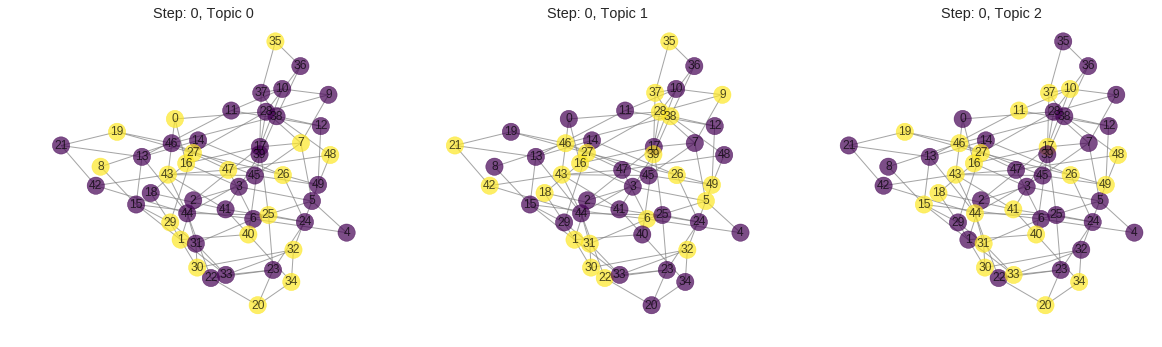

<Figure size 432x288 with 0 Axes>

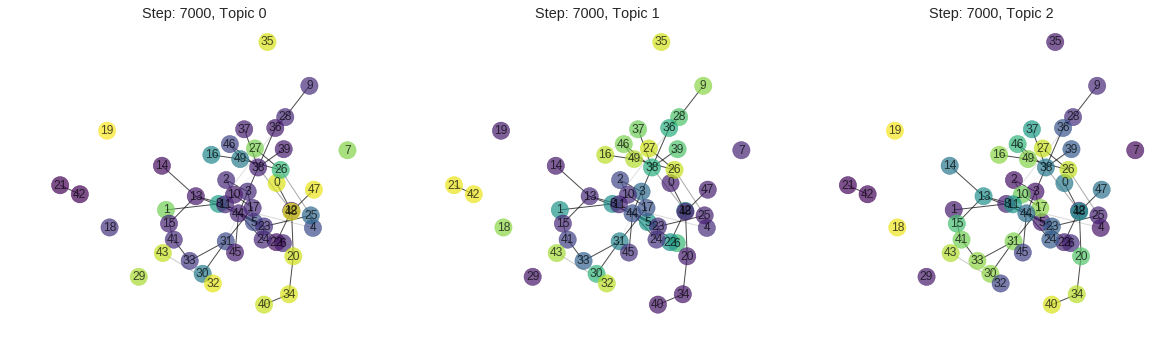

<Figure size 432x288 with 0 Axes>

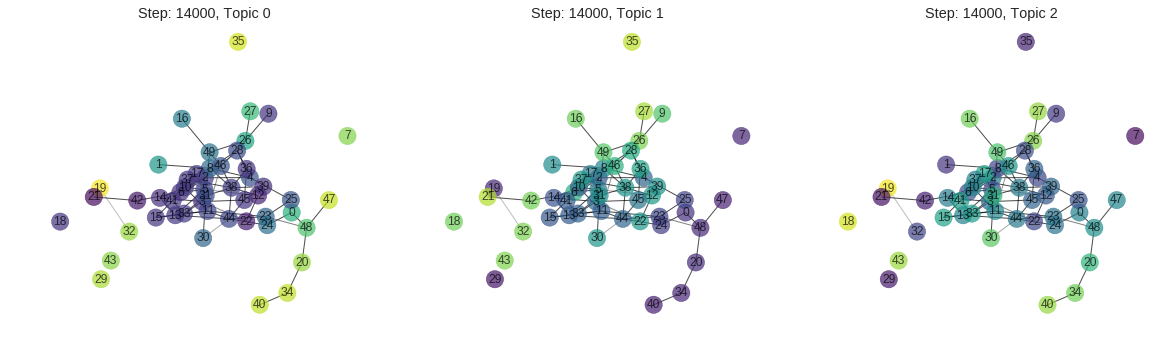

<Figure size 432x288 with 0 Axes>

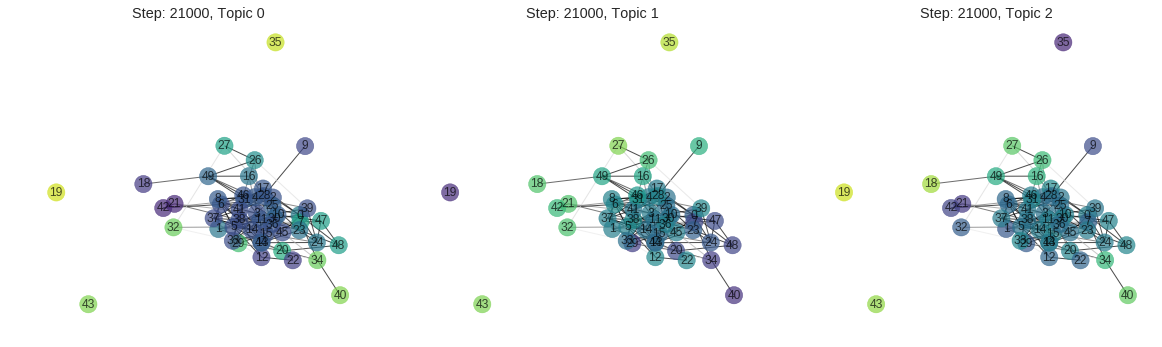

In [56]:
sim = SocialDynamicsSimulation_Tweeter(alpha = 0.03, beta=0.3, n_opinions=3)
sim.initialize()
plt.figure()
sim.observe_n_opinions()
for i in range(3):
    for i in range(7000):
        sim.update()
    plt.figure()
    sim.observe_n_opinions()

In [58]:
tweeter_ave_clust = nx.average_clustering(sim.graph)
tweeter_community_number = nx.community.modularity_max.greedy_modularity_communities(sim.graph)

print("The metrics for a single example of the model with all implementations for 3 topics:")
print("Average Clustering coefficient: ", tweeter_ave_clust)
print("Number of communities: ", len(tweeter_community_number))

The metrics for a single example of the model with all implementations for 3 topics:
Average Clustering coefficient:  0.09712842712842713
Number of communities:  10


We can see in the model with all the implementations initially suggested that nodes seemed to be clustered more than before, however, this will not be formally tested due to time constraints.

## References

Clauset, A., Newman, M. E., & Moore, C. (2004). Finding community structure in very large networks. Physical review E, 70(6), 066111.

Saramäki, J., Kivelä, M., Onnela, J. P., Kaski, K., & Kertesz, J. (2007). Generalizations of the clustering coefficient to weighted complex networks. Physical Review E, 75(2), 027105.
